In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
# spark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    print((df.count(), len(df.columns)))

# Load data
**dataset from RFM with PySpark**

In [5]:
# rfm_numbers = spark.read.csv('V:\data_Science\CustomerSegmentation\data.csv\new.csv', header=True)
rfm_numbers = spark.read.format("csv").option("header", "true").load("improved_data.csv")
rfm_numbers = rfm_numbers.drop('_c0')
printdf(rfm_numbers)

,CustomerId,Recency,Frequency,Monetary
0,16250,283,24,389.44
1,15574,199,168,702.2500000000002
2,15555,34,925,4758.200000000001
3,15271,29,275,2485.8199999999997
4,17714,342,10,153.0


<!-- # Prepare data -->

# Inspect

In [38]:
df_rfm_numbers = rfm_numbers.toPandas()
df_rfm_numbers.describe()

,CustomerId,Recency,Frequency,Monetary
count,4372,4373,4373,4373
unique,4372,304,475,4315
top,16250,23,1,0.0
freq,1,116,79,7


# K-Means Clustering

In [6]:
# Since log transformation doesn't work with negative and zero values, lets get rid of negative and zeros

rfm_data = (
    rfm_numbers.withColumn("Monetary", F.when(F.col("Monetary") <= 0, 1).otherwise(F.col("Monetary")))
)

# rfm_data = rfm_numbers
# printdf(rfm_data)

# Elbow Analysis

In [7]:
features = rfm_data.columns[1:]

printdf(rfm_data)

,CustomerId,Recency,Frequency,Monetary
0,16250,283,24,389.44
1,15574,199,168,702.2500000000002
2,15555,34,925,4758.200000000001
3,15271,29,275,2485.8199999999997
4,17714,342,10,153.0


In [8]:
type(rfm_data)
rfm_data.describe()

DataFrame[summary: string, CustomerId: string, Recency: string, Frequency: string, Monetary: string]

In [9]:
# rfm_data.select(col("age").cast('int').alias("age"))
# rfm_data.withColumn("CustomerID",rfm_data.CustomerID.cast())
rfm_data = rfm_data.withColumn("CustomerID", rfm_data["CustomerID"].cast('double'))
rfm_data = rfm_data.withColumn("Recency", rfm_data["Recency"].cast('double'))
rfm_data = rfm_data.withColumn("Frequency", rfm_data["Frequency"].cast('double'))
rfm_data = rfm_data.withColumn("Monetary", rfm_data["Monetary"].cast('double'))




In [49]:
display(rfm_data)

DataFrame[CustomerID: double, Recency: double, Frequency: double, Monetary: double]

In [39]:
assembler = VectorAssembler(
    inputCols=rfm_data.columns[1:], 
    outputCol="rfm_features")

assembled_data = assembler.transform(rfm_data)

assembled_data = assembled_data.select('CustomerID','rfm_features')

printdf(assembled_data)

,CustomerID,rfm_features
0,16250.0,"[283.0, 24.0, 389.44]"
1,15574.0,"[199.0, 168.0, 702.2500000000002]"
2,15555.0,"[34.0, 925.0, 4758.200000000001]"
3,15271.0,"[29.0, 275.0, 2485.8199999999997]"
4,17714.0,"[342.0, 10.0, 153.0]"


In [40]:
scaler = StandardScaler(
inputCol='rfm_features',
outputCol='rfm_standardized',withStd=True,withMean=False)
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)

scaled_data.select('rfm_standardized').show(5)


+--------------------+
|    rfm_standardized|
+--------------------+
|[2.80837186452121...|
|[1.97479152310855...|
|[0.33740156676226...|
|[0.28778368929722...|
|[3.39386281860867...|
+--------------------+
only showing top 5 rows



In [48]:
printdf(scaled_data)

,CustomerID,rfm_features,rfm_standardized
0,16250.0,"[283.0, 24.0, 389.44]","[2.808371864521214, 0.011681848709304679, 0.01..."
1,15574.0,"[199.0, 168.0, 702.2500000000002]","[1.9747915231085567, 0.08177294096513275, 0.03..."
2,15555.0,"[34.0, 925.0, 4758.200000000001]","[0.33740156676226596, 0.45023791900445115, 0.2..."
3,15271.0,"[29.0, 275.0, 2485.8199999999997]","[0.28778368929722686, 0.13385451646078278, 0.1..."
4,17714.0,"[342.0, 10.0, 153.0]","[3.3938628186086754, 0.004867436962210283, 0.0..."


In [42]:
# working with `scaled_data`
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

costs = {}

# for k in range(2, 10):
#     k_means = KMeans(featuresCol='rfm_standardized', k=k)
#     model = k_means.fit(scaled_data)
#     # costs[k] = model.computeCost(scaled_data)
#     predictions = model.transform(scaled_data)
#     evaluator = ClusteringEvaluator()

#     costs[k] = evaluator.evaluate(predictions)


evaluator = ClusteringEvaluator(predictionCol = 'prediction',featuresCol = 'rfm_standardized', metricName = 'silhouette', distanceMeasure = 'squaredEuclidean')
for i in range(2,10):
    kmeans=KMeans(featuresCol='rfm_standardized', k=i)
    model=kmeans.fit(scaled_data)
    predictions=model.transform(scaled_data)
    score=evaluator.evaluate(predictions)
    costs[i] = score
    # print('Silhouette Score for k =',i,'is',score)

Text(0, 0.5, 'cost')

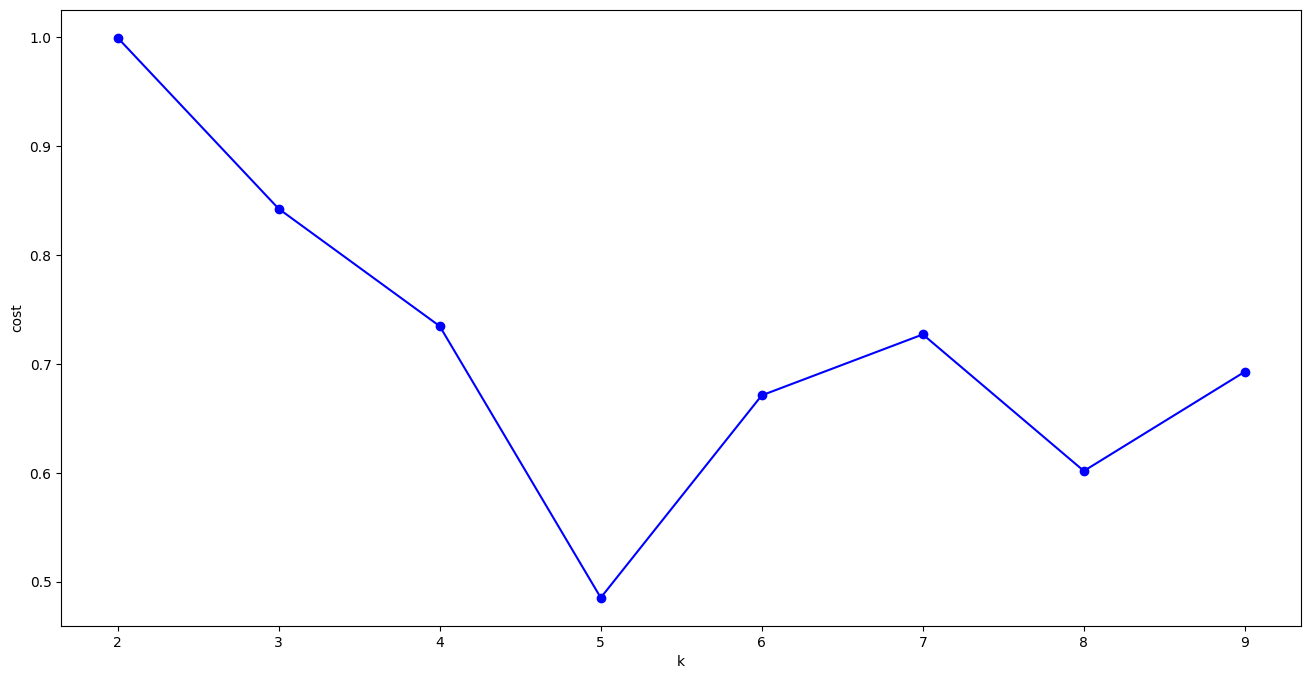

In [43]:
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(costs.keys(), costs.values(), '-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')

# ax.plot(3, costs[3], 'bo')

# K = 5


In [44]:
k_means = KMeans(featuresCol='rfm_standardized', k=5)
model = k_means.fit(scaled_data)
model.transform(scaled_data).groupBy('prediction').count().show()
# predictions.count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         3| 1076|
|         4|  629|
|         2|  506|
|         0| 2161|
+----------+-----+



In [45]:
df = model.transform(scaled_data).groupBy('prediction').count()

In [35]:
df.toPandas().to_csv('prediction.csv')

In [46]:
predictions = model.transform(scaled_data)
predictions.show()

+----------+--------------------+--------------------+----------+
|CustomerID|        rfm_features|    rfm_standardized|prediction|
+----------+--------------------+--------------------+----------+
|   16250.0| [283.0,24.0,389.44]|[2.80837186452121...|         2|
|   15574.0|[199.0,168.0,702....|[1.97479152310855...|         4|
|   15555.0|[34.0,925.0,4758....|[0.33740156676226...|         0|
|   15271.0|[29.0,275.0,2485....|[0.28778368929722...|         0|
|   17714.0|  [342.0,10.0,153.0]|[3.39386281860867...|         2|
|   17686.0|[29.0,286.0,5739.46]|[0.28778368929722...|         0|
|   17757.0|[23.0,742.0,5585....|[0.22824223633917...|         0|
|   17551.0| [381.0,43.0,306.84]|[3.78088226283598...|         2|
|   13187.0|[359.0,37.0,236.0...|[3.56256360198980...|         2|
|   16549.0|[32.0,981.0,4154....|[0.31755441577625...|         0|
|   12637.0|[89.0,394.0,5953.25]|[0.88319821887769...|         3|
|   15052.0| [341.0,30.0,215.78]|[3.38393924311566...|         2|
|   15448.

In [ ]:
# predictions.select(predictions['rfm_features']).show()

In [ ]:
# predictions.select(predictions['rfm_features']).where(predictions.prediction == 1).show()

# Observation

In [51]:
# combined_df = rfm_data.add(predictions, rfm_data['CustomerID'] == predictions['CustomerID'] )

df1 = rfm_data.toPandas()
df2 = predictions.toPandas()

In [59]:
analysis_df = pd.merge(df1,df2,left_on=['CustomerID'],right_on=['CustomerID'],how='inner')
anay

,CustomerID,Recency,Frequency,Monetary,rfm_features,rfm_standardized,prediction
0,16250.0,283.0,24.0,389.44,"[283.0, 24.0, 389.44]","[2.808371864521214, 0.011681848709304679, 0.01...",2
1,15574.0,199.0,168.0,702.25,"[199.0, 168.0, 702.2500000000002]","[1.9747915231085567, 0.08177294096513275, 0.03...",4
2,15555.0,34.0,925.0,4758.20,"[34.0, 925.0, 4758.200000000001]","[0.33740156676226596, 0.45023791900445115, 0.2...",0
3,15271.0,29.0,275.0,2485.82,"[29.0, 275.0, 2485.8199999999997]","[0.28778368929722686, 0.13385451646078278, 0.1...",0
4,17714.0,342.0,10.0,153.00,"[342.0, 10.0, 153.0]","[3.3938628186086754, 0.004867436962210283, 0.0...",2
...,...,...,...,...,...,...,...
4368,14893.0,31.0,73.0,1237.85,"[31.0, 73.0, 1237.8500000000001]","[0.3076308402832425, 0.03553228982413507, 0.05...",0
4369,12660.0,33.0,13.0,245.10,"[33.0, 13.0, 245.09999999999997]","[0.32747799126925814, 0.006327668050873368, 0....",0
4370,17806.0,33.0,43.0,546.04,"[33.0, 43.0, 546.0399999999998]","[0.32747799126925814, 0.020929978937504215, 0....",0
4371,17247.0,37.0,55.0,282.19,"[37.0, 55.0, 282.18999999999994]","[0.3671722932412894, 0.026770903292156555, 0.0...",0


In [66]:
fd = spark.createDataFrame(final_df)

<Axes: xlabel='prediction', ylabel='Monetary'>

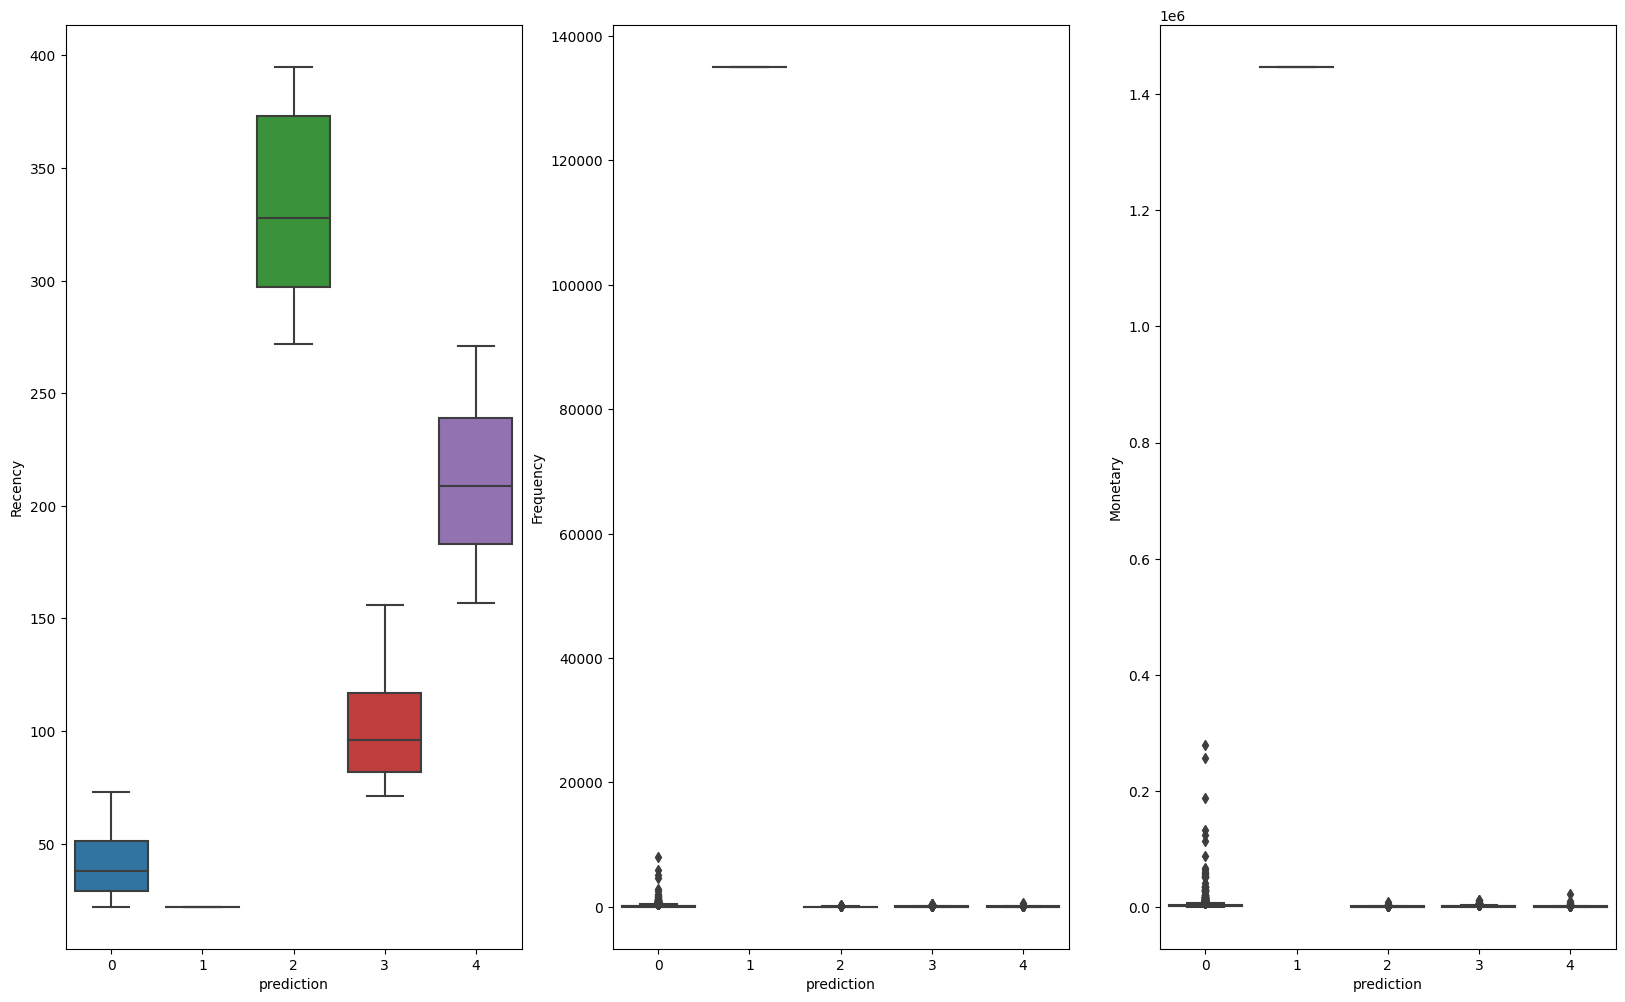

In [64]:
# analysis_df = predictions.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Recency', data=final_df, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=final_df, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=final_df, ax=ax[2])

# Visualization

In [ ]:
display(final_df)

<Axes: xlabel='Monetary', ylabel='Frequency'>

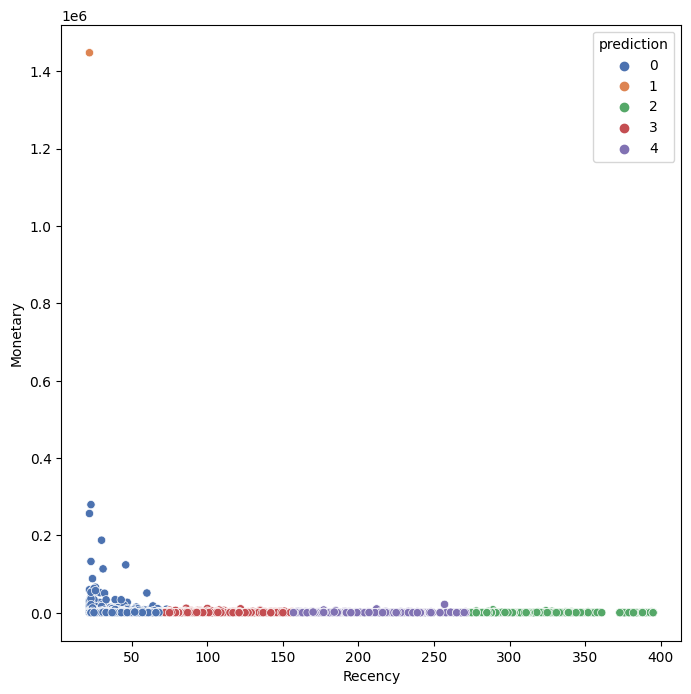

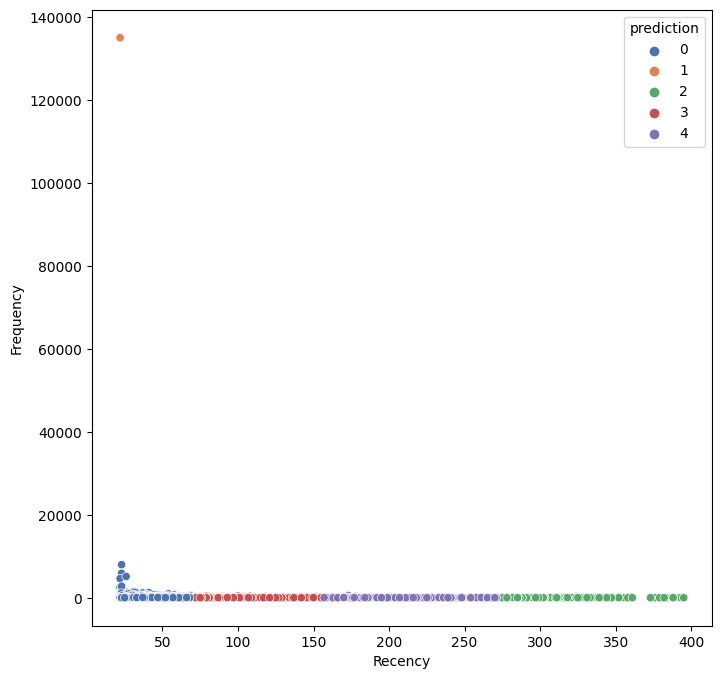

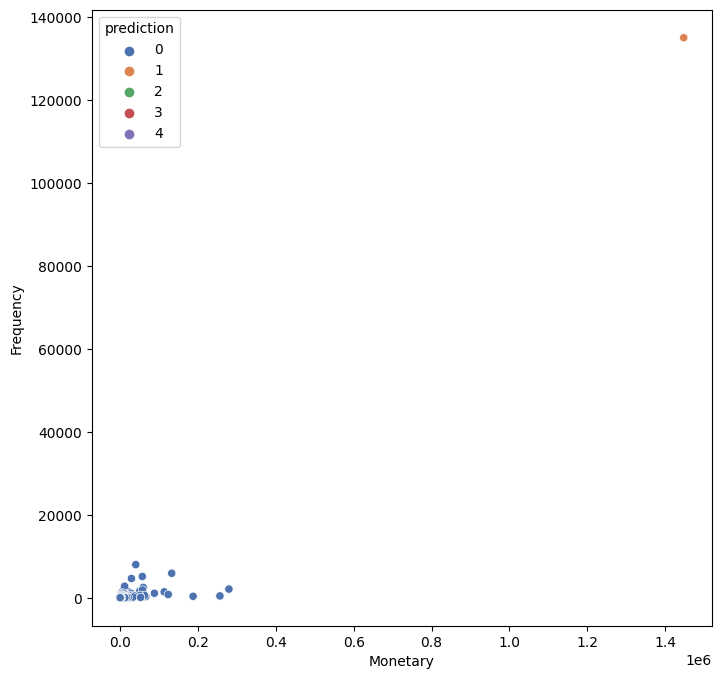

In [63]:
selected_result_df = final_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

In [67]:
analysis = fd\
    .groupBy('prediction')\
    .agg(F.avg('Recency').alias('Avg Recency'),
         F.avg('Frequency').alias('Avg Frequency'),
         F.avg('Monetary').alias('Avg Monetary'))


Py4JJavaError: An error occurred while calling o2804.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 1061.0 failed 1 times, most recent failure: Lost task 3.0 in stage 1061.0 (TID 989) (DESKTOP-KFO9QH5 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more
